In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from datetime import datetime
import boto3
import pandas as pd
from sagemaker import get_execution_role



In [55]:
role = get_execution_role()
bucket='relax-challenge'
data_key = 'relax_challenge/takehome_user_engagement.csv'
data_location = 's3://{0}/{1}'.format(bucket, data_key)
df_engage = pd.read_csv(data_location)

In [20]:
df_engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [16]:
data_key = 'relax_challenge/takehome_users.csv'
data_location = 's3://{0}/{1}'.format(bucket, data_key)
df_users = pd.read_csv(data_location, encoding='iso-8859-1')

In [21]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [23]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [58]:
#the data dictionary tells us that "last_session_creation_time" is UNIX, which means can convert the values to date datetime 
#by specifying seconds 
df_users['creation_time'] = pd.to_datetime(df_users['creation_time'])
df_users['last_session_creation_time'] = pd.to_datetime(df_users['last_session_creation_time'], unit='s')
df_users.info()
df_engage['time_stamp'] = pd.to_datetime(df_engage['time_stamp'])
df_engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB
<class 'pandas.core.frame.DataFrame'>
Ra

In [35]:
#ensure no duplicate users 
duplicate_obj = df_users[df_users.duplicated('object_id')]
duplicate_obj.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id


In [45]:
# tvistied column is always 1, indicating a visit. not useful, can drop
print(df_engage['visited'].nunique())
df_engage.drop('visited', axis=1, inplace=True) 

1


In [61]:
df_engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [65]:
adopted_ids = []
for x in df_engage['user_id'].unique():
    logins = df_engage[df_engage['user_id'] == x].time_stamp.dt.date.unique()
    if len(logins) >= 3:
        for day in range(2,len(logins)): #this creates a sort of sliding window in order to compare  blocks of combos of 3 three consecutive vistis 
            if (logins[day] - logins[day-2]) <= np.timedelta64(7, 'D'): #thsi ensures that the three logins are only in a 7-day windo
                adopted_ids.append(x)
                break

In [66]:
adopted_ids

[2,
 10,
 20,
 33,
 42,
 43,
 50,
 53,
 60,
 63,
 69,
 74,
 80,
 81,
 82,
 87,
 133,
 135,
 141,
 146,
 153,
 160,
 165,
 168,
 172,
 174,
 185,
 188,
 197,
 200,
 202,
 203,
 209,
 214,
 230,
 245,
 247,
 263,
 265,
 275,
 280,
 283,
 297,
 298,
 305,
 310,
 311,
 321,
 322,
 341,
 345,
 347,
 351,
 362,
 363,
 370,
 383,
 397,
 401,
 418,
 430,
 445,
 450,
 460,
 462,
 469,
 471,
 472,
 478,
 479,
 483,
 492,
 494,
 497,
 502,
 506,
 509,
 510,
 512,
 518,
 520,
 522,
 529,
 535,
 540,
 547,
 553,
 564,
 572,
 589,
 591,
 601,
 603,
 605,
 618,
 627,
 628,
 632,
 634,
 639,
 669,
 679,
 680,
 717,
 724,
 725,
 728,
 754,
 772,
 783,
 786,
 804,
 828,
 845,
 851,
 869,
 874,
 882,
 885,
 901,
 906,
 907,
 912,
 928,
 932,
 934,
 937,
 943,
 953,
 980,
 985,
 1007,
 1009,
 1013,
 1017,
 1018,
 1026,
 1027,
 1035,
 1039,
 1055,
 1061,
 1072,
 1089,
 1093,
 1094,
 1099,
 1106,
 1107,
 1119,
 1123,
 1124,
 1128,
 1129,
 1136,
 1145,
 1150,
 1151,
 1155,
 1156,
 1163,
 1173,
 1186,
 1196,


In [78]:
#create new column that identifies if adopted or not 
df_users["adopted"] = np.where(df_users["object_id"].isin(adopted_ids), 1, 0)

In [79]:
df_users.head(20)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241.0,0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,NaN,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143.0,1


In [84]:
df_users['creation_year'] = df_users.creation_time.dt.year
df_users['creation_month'] = df_users.creation_time.dt.month
df_users['influencer'] = df_users['object_id'].apply(lambda x: x in df_users['invited_by_user_id'].unique())


In [85]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_year,creation_month,influencer
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,2014,4,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,2013,11,False
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,2013,3,True
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,2013,5,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,2013,1,False


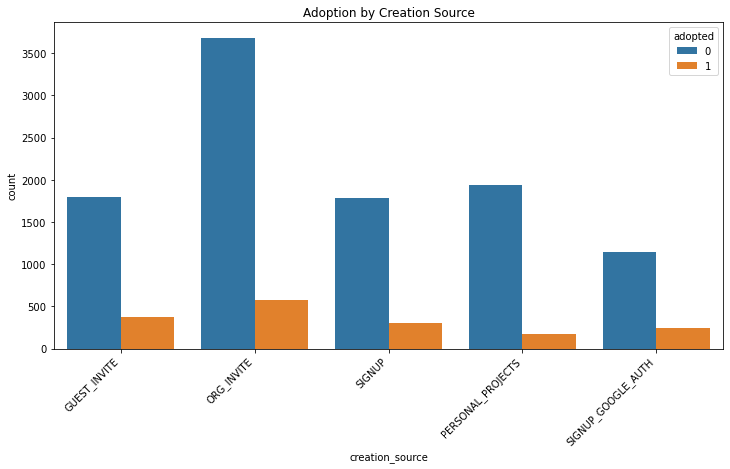

In [96]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x=df_users['creation_source'], hue=df_users['adopted'], data=df_users)
ax.set_title("Adoption by Creation Source")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [103]:
print(len(df_users[(df_users.creation_source == 'ORG_INVITE') & (df_users.adopted == 1)])/len(df_users[df_users.creation_source == 'ORG_INVITE'])) 
print(len(df_users[(df_users.creation_source == 'GUEST_INVITE') & (df_users.adopted == 1)])/len(df_users[df_users.creation_source == 'GUEST_INVITE']))
print(len(df_users[(df_users.creation_source == 'SIGNUP') & (df_users.adopted == 1)])/len(df_users[df_users.creation_source == 'SIGNUP']))
print(len(df_users[(df_users.creation_source == 'PERSONAL_PROJECTS') & (df_users.adopted == 1)])/len(df_users[df_users.creation_source == 'PERSONAL_PROJECTS']))
print(len(df_users[(df_users.creation_source == 'SIGNUP_GOOGLE_AUTH') & (df_users.adopted == 1)])/len(df_users[df_users.creation_source == 'SIGNUP_GOOGLE_AUTH']))

0.13493182886694877
0.17059639389736478
0.14470531863919503
0.08147797252486973
0.17256317689530687


### Creation through Google Auth has highest % of adoptions.

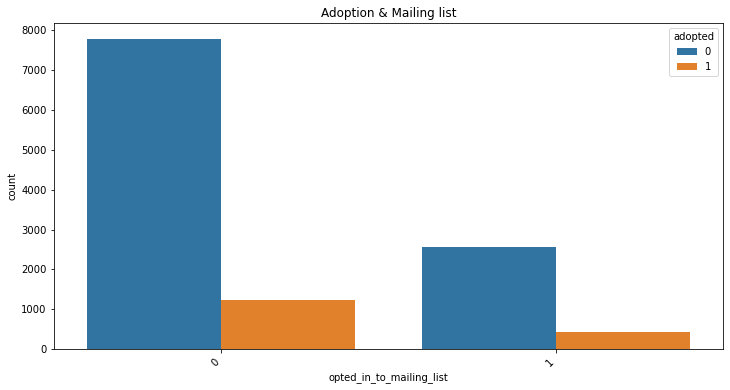

In [105]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x=df_users['opted_in_to_mailing_list'], hue=df_users['adopted'], data=df_users)
ax.set_title("Adoption & Mailing list")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [113]:
df_users.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
adopted                                int64
creation_year                          int64
creation_month                         int64
influencer                          category
dtype: object

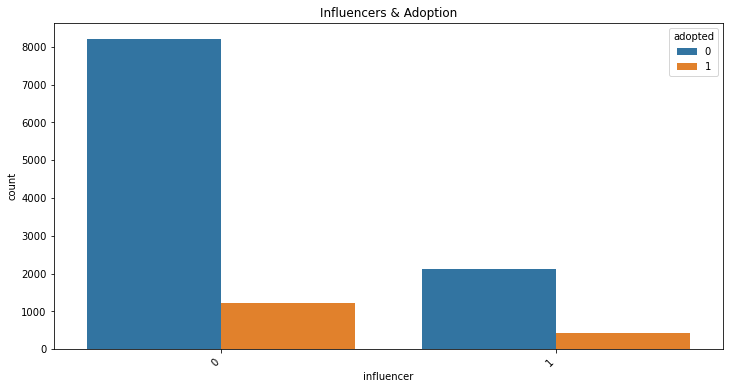

In [114]:
df_users['influencer'] = df_users['influencer'].astype('int')
plt.figure(figsize=(12, 6))
ax = sns.countplot(x=df_users['influencer'], hue=df_users['adopted'], data=df_users)
ax.set_title('Influencers & Adoption')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [117]:
print(len(df_users[(df_users.influencer == 1) & (df_users.adopted == 1)])/len(df_users[df_users.influencer == 1]))
print(len(df_users[(df_users.influencer == 0) & (df_users.adopted == 1)])/len(df_users[df_users.influencer == 0]))

0.17121684867394696
0.12897414158541756


# Being an influencer correlates with a more than 4% increase in adoption liklihood  

In [ ]:
from sklearn.decomposition import PCA
ffrom.sklearnpreporcessing import.StandardScaler 

<AxesSubplot:>

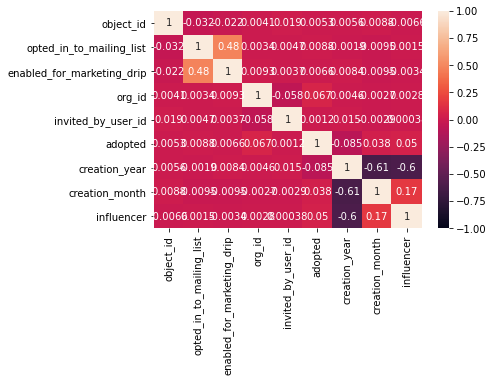

In [119]:
sns.heatmap(df_users.corr(), vmin = -1, vmax = 1, annot=True,)

#### Addtionally PCA should be preformed and before that one-hot encoding should be 
### done on some ofvthe categorical variable, especially the creation source columns. 
### This way the data woill be more amnebale for ML modeling. 